In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=cc75c3944f5d0527819c0e1991f4c329c96d1cc14b0079c29885999f35d3c0cb
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [30]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, when, corr, sum as spark_sum
from pyspark.sql import Window

In [60]:
spark = SparkSession.builder \
    .appName("Connect_Postgre") \
    .config("spark.jars", "/content/postgresql-42.7.3.jar") \
    .getOrCreate()


url = "jdbc:postgresql://postgresql-hackathon2024.alwaysdata.net:5432/hackathon2024_2"
properties = {
    "user": "hackathon2024",
    "password": "bsaebno2001",
    "driver": "org.postgresql.Driver"
}

def load_table(table_name):
    return spark.read.jdbc(url=url, table=table_name, properties=properties)

tables = ["olympic_athletes", "olympic_hosts", "olympic_medals", "olympic_results"]

dataframes = {}
for table in tables:
    dataframes[table] = load_table(table)
    print(f"Données de la table {table} chargées avec succès")

for table, df in dataframes.items():
    print(f"Table: {table}")
    df.show(5)

Données de la table olympic_athletes chargées avec succès
Données de la table olympic_hosts chargées avec succès
Données de la table olympic_medals chargées avec succès
Données de la table olympic_results chargées avec succès
Table: olympic_athletes
+--------------------+--------------+--------------------+------------------+---+----------------+--------------------+----------+------------+------------+------------+------+-----------+---------+
|   athlete_full_name|athlete_medals|         athlete_url|athlete_year_birth|bio|      first_game|games_participations|total_gold|total_silver|total_bronze|total_medals|is_new|athlete_age|firstname|
+--------------------+--------------+--------------------+------------------+---+----------------+--------------------+----------+------------+------------+------------+------+-----------+---------+
|Cooper WOODS-TOPA...|             0|https://olympics....|              2000|   |    Beijing 2022|                   1|         0|           0|          

In [61]:
df_test = spark.read.jdbc(url=url, table="olympic_results", properties=properties).alias("results")
df_test.select('discipline_title').distinct().show()

+--------------------+
|    discipline_title|
+--------------------+
|              Tennis|
|              Boxing|
|   Marathon Swimming|
|                Golf|
|              Rowing|
|                Judo|
|             Sailing|
|            Swimming|
|         Cycling BMX|
|Cycling BMX Frees...|
|       Alpine Skiing|
| Rhythmic Gymnastics|
|            Biathlon|
|              Karate|
|           Triathlon|
|           Badminton|
|        Canoe Sprint|
|           Athletics|
|      Figure skating|
|       Cycling Track|
+--------------------+
only showing top 20 rows



In [59]:
spark.stop()

In [20]:
# Initialiser la session Spark
spark = SparkSession.builder \
    .appName("CalculateAthleteAgeAtOlympics") \
    .config("spark.jars.packages", "/content/postgresql-42.7.3.jar") \
    .getOrCreate()

# Informations de connexion
url = "jdbc:postgresql://postgresql-hackathon2024.alwaysdata.net:5432/hackathon2024_2"
properties = {
    "user": "hackathon2024",
    "password": "bsaebno2001",
    "driver": "org.postgresql.Driver"
}

# Charger les tables
df_athletes = spark.read.jdbc(url=url, table="olympic_athletes", properties=properties).alias("athletes")
df_hosts = spark.read.jdbc(url=url, table="olympic_hosts", properties=properties).alias("hosts")
df_results = spark.read.jdbc(url=url, table="olympic_results", properties=properties).alias("results")

# Jointure des tables athletes et results sur athlete_url
df = df_athletes.join(df_results, df_athletes.athlete_url == df_results.athlete_url, how='inner')

# Jointure avec la table hosts sur game_slug
df = df.join(df_hosts, df_results.slug_game == df_hosts.game_slug, how='inner')

# Créer une colonne "medal_type_index" pour la classification
df = df.withColumn("medal_type_index",
                   when(col("medal_type") == "GOLD", 3)
                   .when(col("medal_type") == "SILVER", 2)
                   .when(col("medal_type") == "BRONZE", 1)
                   .otherwise(0))

df = df.filter(df.medal_type_index > 0)

# Calculer l'âge des athlètes lors des JO
df = df.withColumn("athlete_age_at_game", col("hosts.game_year") - col("athletes.athlete_year_birth"))

# Sélectionner les colonnes d'intérêt
df = df.select(
    col("athletes.athlete_full_name").alias("athlete_full_name"),
    col("athletes.athlete_year_birth").alias("athlete_year_birth"),
    col("athletes.games_participations").alias("games_participations"),
    col("athletes.athlete_age").alias("athlete_age"),
    col("athlete_age_at_game"),
    col("hosts.game_year").alias("game_year"),
    col("hosts.game_location").alias("game_location"),
    col("hosts.game_season").alias("game_season"),
    col("results.rank_position").alias("rank_position"),
    col("medal_type_index")
)

# Afficher les résultats
df.show(10)


+--------------------+------------------+--------------------+-----------+-------------------+---------+------------------+-----------+-------------+----------------+
|   athlete_full_name|athlete_year_birth|games_participations|athlete_age|athlete_age_at_game|game_year|     game_location|game_season|rank_position|medal_type_index|
+--------------------+------------------+--------------------+-----------+-------------------+---------+------------------+-----------+-------------+----------------+
|  Alessandra PERILLI|              1988|                   3|         36|               32.0|     2020|             Japan|     Summer|            3|               1|
|             Long MA|              1988|                   3|         36|               28.0|     2016|            Brazil|     Summer|            1|               3|
|             Long MA|              1988|                   3|         36|               32.0|     2020|             Japan|     Summer|            1|               3

In [21]:
df.describe().show()

+-------+------------------+------------------+--------------------+------------------+-------------------+------------------+------------------+-----------+------------------+------------------+
|summary| athlete_full_name|athlete_year_birth|games_participations|       athlete_age|athlete_age_at_game|         game_year|     game_location|game_season|     rank_position|  medal_type_index|
+-------+------------------+------------------+--------------------+------------------+-------------------+------------------+------------------+-----------+------------------+------------------+
|  count|              2477|              2477|                2477|              2477|               2477|              2477|              2477|       2477|              2477|              2477|
|   mean|              NULL|1990.4860718611224|    2.33589018974566|33.513928138877674| 26.843762616067824|2017.3298344771902|              NULL|       NULL|2.0375454178441665|1.9600322971336295|
| stddev|           

In [22]:
correlations = df.select(
    corr('athlete_year_birth', 'medal_type_index').alias('athlete_year_birth_corr'),
    corr('games_participations', 'medal_type_index').alias('games_participations_corr'),
    corr('athlete_age', 'medal_type_index').alias('athlete_age_corr'),
    corr('athlete_age_at_game', 'medal_type_index').alias('athlete_age_at_game_corr'),
    corr('game_year', 'medal_type_index').alias('game_year_corr'),
    corr('rank_position', 'medal_type_index').alias('rank_position_corr')
)

correlations.show()


+-----------------------+-------------------------+--------------------+------------------------+--------------------+-------------------+
|athlete_year_birth_corr|games_participations_corr|    athlete_age_corr|athlete_age_at_game_corr|      game_year_corr| rank_position_corr|
+-----------------------+-------------------------+--------------------+------------------------+--------------------+-------------------+
|   0.015399960173988925|      0.05528054953330963|-0.01539996017398...|    -0.02634772605951...|-0.01754017684412...|-0.9982226281763212|
+-----------------------+-------------------------+--------------------+------------------------+--------------------+-------------------+



In [19]:
spark.stop()

In [24]:


# Initialiser la session Spark
spark = SparkSession.builder \
    .appName("Test2") \
    .config("spark.jars.packages", "/content/postgresql-42.7.3.jar") \
    .getOrCreate()

# Informations de connexion
url = "jdbc:postgresql://postgresql-hackathon2024.alwaysdata.net:5432/hackathon2024_2"
properties = {
    "user": "hackathon2024",
    "password": "bsaebno2001",
    "driver": "org.postgresql.Driver"
}

# Charger les tables
df_athletes = spark.read.jdbc(url=url, table="olympic_athletes", properties=properties).alias("athletes")
df_hosts = spark.read.jdbc(url=url, table="olympic_hosts", properties=properties).alias("hosts")
df_results = spark.read.jdbc(url=url, table="olympic_results", properties=properties).alias("results")

# Jointure des tables athletes et results sur athlete_url
df = df_athletes.join(df_results, df_athletes.athlete_url == df_results.athlete_url, how='inner')

# Jointure avec la table hosts sur game_slug
df = df.join(df_hosts, df_results.slug_game == df_hosts.game_slug, how='inner')

# Créer une colonne "medal_type_index" pour la classification
df = df.withColumn("medal_type_index",
                   when(col("medal_type") == "GOLD", 3)
                   .when(col("medal_type") == "SILVER", 2)
                   .when(col("medal_type") == "BRONZE", 1)
                   .otherwise(0))

# Calculer l'âge des athlètes lors des JO
df = df.withColumn("athlete_age_at_game", col("hosts.game_year") - col("athletes.athlete_year_birth"))

# Sélectionner les colonnes d'intérêt
df = df.select(
    col("athletes.athlete_full_name").alias("athlete_full_name"),
    col("athletes.athlete_year_birth").alias("athlete_year_birth"),
    col("athletes.games_participations").alias("games_participations"),
    col("athletes.athlete_age").alias("athlete_age"),
    col("athlete_age_at_game"),
    col("hosts.game_year").alias("game_year"),
    col("hosts.game_location").alias("game_location"),
    col("hosts.game_season").alias("game_season"),
    col("results.rank_position").alias("rank_position"),
    col("medal_type_index"),
    col("results.medal_type").alias("medal_type"),
    col("results.slug_game").alias("slug_game")
)

# Calculer le nombre de médailles accumulées par athlète avant chaque participation
window_spec = Window.partitionBy("athlete_full_name").orderBy("game_year").rowsBetween(Window.unboundedPreceding, -1)
df = df.withColumn("medals_accumulated",
                   spark_sum(when(col("medal_type") == "GOLD", 1).otherwise(0) +
                             when(col("medal_type") == "SILVER", 1).otherwise(0) +
                             when(col("medal_type") == "BRONZE", 1).otherwise(0))
                   .over(window_spec))

# Remplacer les valeurs nulles par 0
df = df.na.fill(0, subset=["medals_accumulated"])

# Afficher les résultats
df.select("athlete_full_name", "game_year", "medal_type", "medals_accumulated").show(10)


+-----------------+---------+----------+------------------+
|athlete_full_name|game_year|medal_type|medals_accumulated|
+-----------------+---------+----------+------------------+
|        DENI DENI|     2016|      NONE|                 0|
|           . DENI|     2020|      NONE|                 0|
|       . PRIYANKA|     2020|      NONE|                 0|
|          . RAHUL|     2020|      NONE|                 0|
|         A J HURT|     2022|      NONE|                 0|
|         A J HURT|     2022|      NONE|                 0|
|     Aaron BLUNCK|     2014|      NONE|                 0|
|     Aaron BLUNCK|     2018|      NONE|                 0|
|     Aaron BLUNCK|     2022|      NONE|                 0|
|      Aaron BROWN|     2020|      NONE|                 0|
+-----------------+---------+----------+------------------+
only showing top 10 rows



In [25]:
df.select('medals_accumulated').distinct().show()

+------------------+
|medals_accumulated|
+------------------+
|                 0|
|                 6|
|                 5|
|                 1|
|                 3|
|                 2|
|                 4|
+------------------+



In [27]:
df_with_medals = df.filter(df.medal_type.isin(["GOLD", "SILVER", "BRONZE"]))
df_with_medals.select("athlete_full_name", "game_year", "medal_type", "medals_accumulated").show(20)

+--------------------+---------+----------+------------------+
|   athlete_full_name|game_year|medal_type|medals_accumulated|
+--------------------+---------+----------+------------------+
|          Aaron WOLF|     2020|      GOLD|                 0|
|   Abdalaati IGUIDER|     2012|    BRONZE|                 0|
|Abdel Rahman ALMA...|     2020|    BRONZE|                 0|
|        Abdi NAGEEYE|     2020|    SILVER|                 0|
|Abdoulrazak ISSOU...|     2016|    SILVER|                 0|
|  Abdullah ALRASHIDI|     2016|    BRONZE|                 0|
|  Abdullah ALRASHIDI|     2020|    BRONZE|                 1|
|Abdulrashid SADULAEV|     2020|      GOLD|                 0|
|          Abel KIRUI|     2012|    SILVER|                 0|
|   Abel Kiprop MUTAI|     2012|    BRONZE|                 0|
|     Abishag SEMBERG|     2020|    BRONZE|                 0|
|      Abner TEIXEIRA|     2020|    BRONZE|                 0|
|Abraham de Jesus ...|     2020|    BRONZE|            

In [42]:
spark.stop()

In [39]:
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col, when, avg, round

# Initialiser la session Spark
spark = SparkSession.builder \
    .appName("OlympicMedalPrediction1") \
    .config("spark.jars.packages", "org.postgresql:postgresql:42.2.19") \
    .getOrCreate()

# URL de connexion et propriétés
url = "jdbc:postgresql://postgresql-hackathon2024.alwaysdata.net:5432/hackathon2024_2"
properties = {
    "user": "hackathon2024",
    "password": "bsaebno2001",
    "driver": "org.postgresql.Driver"
}

# Charger les tables
df_athletes = spark.read.jdbc(url=url, table="olympic_athletes", properties=properties).alias("athletes")
df_hosts = spark.read.jdbc(url=url, table="olympic_hosts", properties=properties).alias("hosts")
df_results = spark.read.jdbc(url=url, table="olympic_results", properties=properties).alias("results")

# Filtrer les résultats pour les Jeux Olympiques d'été
summer_games_slugs = df_hosts.filter(df_hosts.game_season == "Summer").select("game_slug").rdd.flatMap(lambda x: x).collect()
df_results = df_results.filter(df_results.slug_game.isin(summer_games_slugs))

# Joindre les tables pour obtenir un ensemble de données complet
df = df_athletes.join(df_results, df_athletes.athlete_url == df_results.athlete_url, how='inner')
df = df.join(df_hosts, df_results.slug_game == df_hosts.game_slug, how='inner')

# Calculer l'âge des athlètes lors des JO
df = df.withColumn("athlete_age_at_game", col("hosts.game_year") - col("athletes.athlete_year_birth"))

# Créer une colonne "medal_type_index" pour la classification
df = df.withColumn("medal_type_index",
                   when(col("results.medal_type") == "GOLD", 3)
                   .when(col("results.medal_type") == "SILVER", 2)
                   .when(col("results.medal_type") == "BRONZE", 1)
                   .otherwise(0))

# Calculer la position moyenne par pays
window_spec = Window.partitionBy("country_name")
df = df.withColumn("avg_rank_position", avg("rank_position").over(window_spec))

# Ajouter le total de médailles des athlètes
df = df.withColumn("total_medals", col("athletes.total_medals"))

# Catégoriser les âges et les positions
df = df.withColumn("age_category",
                   when(col("athlete_age_at_game").between(18, 22), 1)
                   .when(col("athlete_age_at_game").between(23, 27), 2)
                   .otherwise(3))

df = df.withColumn("rank_category",
                   when(col("avg_rank_position").between(1, 25), 1)
                   .when(col("avg_rank_position").between(26, 50), 2)
                   .when(col("avg_rank_position").between(51, 75), 3)
                   .otherwise(4))

# Sélectionner les colonnes d'intérêt
df = df.select(
    col("athletes.athlete_full_name"),
    col("results.country_name"),
    col("athlete_age_at_game"),
    col("avg_rank_position"),
    col("total_medals"),
    col("medal_type_index"),
    col("age_category"),
    col("rank_category")
)

# Convertir les données Spark DataFrame en Pandas DataFrame
df_pandas = df.toPandas()

# Afficher le schéma et un échantillon de données
df_pandas.info()
df_pandas.head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15413 entries, 0 to 15412
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   athlete_full_name    15413 non-null  object 
 1   country_name         15413 non-null  object 
 2   athlete_age_at_game  15413 non-null  float64
 3   avg_rank_position    15411 non-null  float64
 4   total_medals         15413 non-null  int32  
 5   medal_type_index     15413 non-null  int32  
 6   age_category         15413 non-null  int32  
 7   rank_category        15413 non-null  int32  
dtypes: float64(2), int32(4), object(2)
memory usage: 722.6+ KB


,athlete_full_name,country_name,athlete_age_at_game,avg_rank_position,total_medals,medal_type_index,age_category,rank_category
0,Mohammad Tawfiq BAKHSHI,Afghanistan,30.0,30.333333,0,0,3,2
1,Mahdi YOVARI,Afghanistan,23.0,30.333333,0,0,2,2
2,Farzad MANSOURI,Afghanistan,18.0,30.333333,0,0,1,2
3,Sidni HOXHA,Albania,20.0,25.357143,0,0,1,4
4,Noel BORSHI,Albania,16.0,25.357143,0,0,3,4
5,Arben KUCANA,Albania,45.0,25.357143,0,0,3,4
6,Arben KUCANA,Albania,45.0,25.357143,0,0,3,4
7,Sidni HOXHA,Albania,24.0,25.357143,0,0,2,4
8,Evagjelia VELI,Albania,25.0,25.357143,0,0,2,4
9,Briken CALJA,Albania,26.0,25.357143,0,0,2,4


In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Préparation des données pour l'entraînement
X = df_pandas[['athlete_age_category', 'rank_position_category']].values
y = df_pandas['medal_type_index'].values


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Construction du modèle
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')  # 4 types de médailles : 0 (aucune), 1 (bronze), 2 (argent), 3 (or)
])

# Compilation du modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=50, validation_split=0.1, verbose=1)

# Évaluation du modèle
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)


Epoch 1/50
347/347 [==============================] - 3s 4ms/step - loss: 0.3678 - accuracy: 0.8784 - val_loss: 0.3003 - val_accuracy: 0.8767
Epoch 2/50
347/347 [==============================] - 2s 4ms/step - loss: 0.2895 - accuracy: 0.8844 - val_loss: 0.2958 - val_accuracy: 0.8783
Epoch 3/50
347/347 [==============================] - 1s 4ms/step - loss: 0.2882 - accuracy: 0.8853 - val_loss: 0.2957 - val_accuracy: 0.8751
Epoch 4/50
347/347 [==============================] - 1s 3ms/step - loss: 0.2870 - accuracy: 0.8838 - val_loss: 0.2919 - val_accuracy: 0.8800
Epoch 5/50
347/347 [==============================] - 1s 2ms/step - loss: 0.2863 - accuracy: 0.8851 - val_loss: 0.2934 - val_accuracy: 0.8800
Epoch 6/50
347/347 [==============================] - 1s 2ms/step - loss: 0.2866 - accuracy: 0.8848 - val_loss: 0.2917 - val_accuracy: 0.8792
Epoch 7/50
347/347 [==============================] - 1s 2ms/step - loss: 0.2863 - accuracy: 0.8849 - val_loss: 0.2916 - val_accuracy: 0.8792
Epoch 

In [45]:
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col, when, avg
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

# Initialiser la session Spark
spark = SparkSession.builder \
    .appName("OlympicMedalPrediction2") \
    .config("spark.jars.packages", "org.postgresql:postgresql:42.2.19") \
    .getOrCreate()

# URL de connexion et propriétés
url = "jdbc:postgresql://postgresql-hackathon2024.alwaysdata.net:5432/hackathon2024_2"
properties = {
    "user": "hackathon2024",
    "password": "bsaebno2001",
    "driver": "org.postgresql.Driver"
}

# Charger les tables
df_athletes = spark.read.jdbc(url=url, table="olympic_athletes", properties=properties).alias("athletes")
df_hosts = spark.read.jdbc(url=url, table="olympic_hosts", properties=properties).alias("hosts")
df_results = spark.read.jdbc(url=url, table="olympic_results", properties=properties).alias("results")

# Filtrer les résultats pour les Jeux Olympiques d'été
summer_games_slugs = df_hosts.filter(df_hosts.game_season == "Summer").select("game_slug").rdd.flatMap(lambda x: x).collect()
df_results = df_results.filter(df_results.slug_game.isin(summer_games_slugs))

# Joindre les tables pour obtenir un ensemble de données complet
df = df_athletes.join(df_results, df_athletes.athlete_url == df_results.athlete_url, how='inner')
df = df.join(df_hosts, df_results.slug_game == df_hosts.game_slug, how='inner')

# Calculer l'âge des athlètes lors des JO
df = df.withColumn("athlete_age_at_game", col("hosts.game_year") - col("athletes.athlete_year_birth"))

# Créer une colonne "medal_type_index" pour la classification
df = df.withColumn("medal_type_index",
                   when(col("results.medal_type") == "GOLD", 3)
                   .when(col("results.medal_type") == "SILVER", 2)
                   .when(col("results.medal_type") == "BRONZE", 1)
                   .otherwise(0))

# Calculer la position moyenne par pays
window_spec = Window.partitionBy("country_name")
df = df.withColumn("avg_rank_position", avg("rank_position").over(window_spec))

# Ajouter le total de médailles des athlètes
df = df.withColumn("total_medals", col("athletes.total_medals"))

# Catégoriser les âges et les positions
df = df.withColumn("age_category",
                   when(col("athlete_age_at_game").between(18, 22), 1)
                   .when(col("athlete_age_at_game").between(23, 27), 2)
                   .otherwise(3))

df = df.withColumn("rank_category",
                   when(col("avg_rank_position").between(1, 25), 1)
                   .when(col("avg_rank_position").between(26, 50), 2)
                   .when(col("avg_rank_position").between(51, 75), 3)
                   .otherwise(4))

# Sélectionner les colonnes d'intérêt
df = df.select(
    col("athletes.athlete_full_name"),
    col("results.country_name"),
    col("results.discipline_title"),
    col("athlete_age_at_game"),
    col("avg_rank_position"),
    col("total_medals"),
    col("medal_type_index"),
    col("age_category"),
    col("rank_category")
)

# Convertir les données Spark DataFrame en Pandas DataFrame
df_pandas = df.toPandas()

# One-hot encoding des variables catégoriques
categorical_features = ['country_name', 'discipline_title']
numeric_features = ['age_category', 'rank_category', 'total_medals']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False), categorical_features)])  # Important: sparse_output=False

X = df_pandas[['country_name', 'discipline_title', 'age_category', 'rank_category', 'total_medals']]
y = df_pandas['medal_type_index']

# Appliquer la transformation
X_transformed = preprocessor.fit_transform(X)

# Séparation des données en ensembles d'entraînement, de validation et de test
X_train, X_temp, y_train, y_temp = train_test_split(X_transformed, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Construction du modèle
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')  # 4 types de médailles (NONE, BRONZE, SILVER, GOLD)
])

# Compilation du modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)

# Évaluation du modèle
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)


Epoch 1/50
338/338 [==============================] - 3s 6ms/step - loss: 0.3556 - accuracy: 0.8819 - val_loss: 0.2779 - val_accuracy: 0.8888
Epoch 2/50
338/338 [==============================] - 2s 5ms/step - loss: 0.2611 - accuracy: 0.8926 - val_loss: 0.2742 - val_accuracy: 0.8884
Epoch 3/50
338/338 [==============================] - 1s 3ms/step - loss: 0.2512 - accuracy: 0.8957 - val_loss: 0.2793 - val_accuracy: 0.8875
Epoch 4/50
338/338 [==============================] - 1s 4ms/step - loss: 0.2426 - accuracy: 0.8989 - val_loss: 0.2818 - val_accuracy: 0.8867
Epoch 5/50
338/338 [==============================] - 1s 3ms/step - loss: 0.2352 - accuracy: 0.9021 - val_loss: 0.2901 - val_accuracy: 0.8871
Epoch 6/50
338/338 [==============================] - 1s 4ms/step - loss: 0.2279 - accuracy: 0.9062 - val_loss: 0.2989 - val_accuracy: 0.8789
Epoch 7/50
338/338 [==============================] - 1s 3ms/step - loss: 0.2197 - accuracy: 0.9107 - val_loss: 0.3086 - val_accuracy: 0.8780
Epoch 

In [46]:
spark.stop()

Epoch 1/50
338/338 [==============================] - 2s 4ms/step - loss: 0.9396 - accuracy: 0.8741 - val_loss: 0.3832 - val_accuracy: 0.8845
Epoch 2/50
338/338 [==============================] - 1s 3ms/step - loss: 0.3617 - accuracy: 0.8843 - val_loss: 0.3344 - val_accuracy: 0.8841
Epoch 3/50
338/338 [==============================] - 1s 4ms/step - loss: 0.3374 - accuracy: 0.8850 - val_loss: 0.3263 - val_accuracy: 0.8832
Epoch 4/50
338/338 [==============================] - 2s 6ms/step - loss: 0.3316 - accuracy: 0.8844 - val_loss: 0.3227 - val_accuracy: 0.8832
Epoch 5/50
338/338 [==============================] - 3s 9ms/step - loss: 0.3268 - accuracy: 0.8845 - val_loss: 0.3194 - val_accuracy: 0.8849
Epoch 6/50
338/338 [==============================] - 2s 7ms/step - loss: 0.3248 - accuracy: 0.8838 - val_loss: 0.3186 - val_accuracy: 0.8837
Epoch 7/50
338/338 [==============================] - 2s 5ms/step - loss: 0.3229 - accuracy: 0.8856 - val_loss: 0.3141 - val_accuracy: 0.8849
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


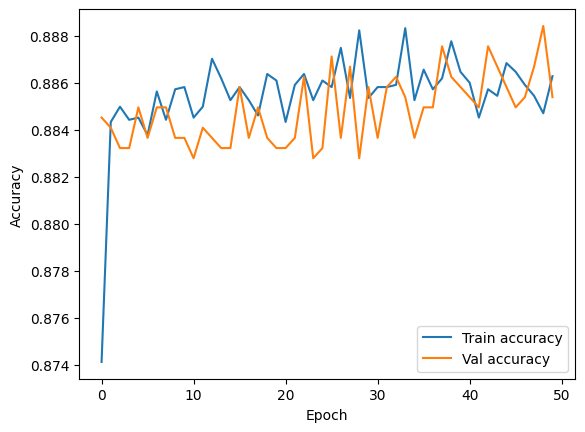

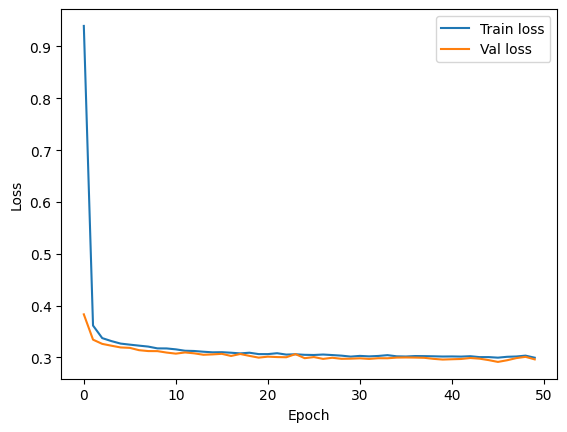

In [53]:
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col, when, avg
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib

# Initialiser la session Spark
spark = SparkSession.builder \
    .appName("OlympicMedalPrediction3") \
    .config("spark.jars.packages", "org.postgresql:postgresql:42.2.19") \
    .getOrCreate()

# URL de connexion et propriétés
url = "jdbc:postgresql://postgresql-hackathon2024.alwaysdata.net:5432/hackathon2024_2"
properties = {
    "user": "hackathon2024",
    "password": "bsaebno2001",
    "driver": "org.postgresql.Driver"
}

# Charger les tables
df_athletes = spark.read.jdbc(url=url, table="olympic_athletes", properties=properties).alias("athletes")
df_hosts = spark.read.jdbc(url=url, table="olympic_hosts", properties=properties).alias("hosts")
df_results = spark.read.jdbc(url=url, table="olympic_results", properties=properties).alias("results")

# Filtrer les résultats pour les Jeux Olympiques d'été
summer_games_slugs = df_hosts.filter(df_hosts.game_season == "Summer").select("game_slug").rdd.flatMap(lambda x: x).collect()
df_results = df_results.filter(df_results.slug_game.isin(summer_games_slugs))

# Joindre les tables pour obtenir un ensemble de données complet
df = df_athletes.join(df_results, df_athletes.athlete_url == df_results.athlete_url, how='inner')
df = df.join(df_hosts, df_results.slug_game == df_hosts.game_slug, how='inner')

# Calculer l'âge des athlètes lors des JO
df = df.withColumn("athlete_age_at_game", col("hosts.game_year") - col("athletes.athlete_year_birth"))

# Cat médailles
df = df.withColumn("medal_type_index",
                   when(col("results.medal_type") == "GOLD", 3)
                   .when(col("results.medal_type") == "SILVER", 2)
                   .when(col("results.medal_type") == "BRONZE", 1)
                   .otherwise(0))

# Calculer la position moyenne par pays
window_spec = Window.partitionBy("country_name")
df = df.withColumn("avg_rank_position", avg("rank_position").over(window_spec))

# Total de médailles des athlètes
df = df.withColumn("total_medals", col("athletes.total_medals"))

# Catégoriser les âges et les positions
df = df.withColumn("age_category",
                   when(col("athlete_age_at_game").between(18, 22), 1)
                   .when(col("athlete_age_at_game").between(23, 27), 2)
                   .otherwise(3))

df = df.withColumn("rank_category",
                   when(col("avg_rank_position").between(1, 25), 1)
                   .when(col("avg_rank_position").between(26, 50), 2)
                   .when(col("avg_rank_position").between(51, 75), 3)
                   .otherwise(4))

df = df.select(
    col("athletes.athlete_full_name"),
    col("results.country_name"),
    col("results.discipline_title"),
    col("athlete_age_at_game"),
    col("avg_rank_position"),
    col("total_medals"),
    col("medal_type_index"),
    col("age_category"),
    col("rank_category")
)

df_pandas = df.toPandas()

# One-hot encoding des variables catégoriques
categorical_features = ['country_name', 'discipline_title']
numeric_features = ['age_category', 'rank_category', 'total_medals']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False), categorical_features)])  # Important: sparse_output=False

X = df_pandas[['country_name', 'discipline_title', 'age_category', 'rank_category', 'total_medals']]
y = df_pandas['medal_type_index']

# Appliquer la transformation
X_transformed = preprocessor.fit_transform(X)

# Train, Validation et de test
X_train, X_temp, y_train, y_temp = train_test_split(X_transformed, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Construction du modèle
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 types (NONE, BRONZE, SILVER, GOLD)
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)

# Model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

# Save model
model.save('olympic_medal_prediction_model.h5')
joblib.dump(preprocessor, 'column_transformer.pkl')

# Courbes apprentissage
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [62]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import joblib

model = load_model('olympic_medal_prediction_model.h5')
preprocessor = joblib.load('column_transformer.pkl')

#Exemple
athlete_data = pd.DataFrame({
    'country_name': ['United States of America'],
    'discipline_title': ['Tennis'],
    'age_category': [2],
    'rank_category': [1],
    'total_medals': [3]
})

# Préprocesseur
athlete_data_transformed = preprocessor.transform(athlete_data)

predictions = model.predict(athlete_data_transformed)
predicted_classes = np.argmax(predictions, axis=1)

# Print pred
medal_probabilities = {
    'None': predictions[0][0],
    'Bronze': predictions[0][1],
    'Silver': predictions[0][2],
    'Gold': predictions[0][3]
}

print(f"Probabilities for athlete: {medal_probabilities}")
print(f"Predicted medal class: {predicted_classes[0]}")


1/1 [==============================] - 0s 109ms/step
Probabilities for athlete: {'None': 0.31700957, 'Bronze': 0.2438875, 'Silver': 0.20717703, 'Gold': 0.23192589}
Predicted medal class: 0


In [63]:
spark.stop()